# PCA and Statistical Analysis on RNA Dataset
**Written by**: Robert Burris

## Part 1: Performing PCA and Plotting PCA Results

### Importing Data and Performing PCA
After loading the data into a Pandas dataframe, cleaning it up, and converting it to a NumPy array, we perform Principal Component Analysis (PCA) on the data matrix using scikit-learn's PCA tool. We then get the percentage of the used variance (`explained_variance_ratio`) which is printed at the end. 

In [141]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

data = pd.read_csv(
    filepath_or_buffer='data_matrix.csv',
    header=None,
    sep=',',
    low_memory=False)

# Clean up data, remove row/column headers 
data = data[[0,1,2,3,4,5,6,7,8,11,12,13,14,15,16,9,10]]
columns = data.iloc[0]
columns = columns.drop(0)
rows = data.iloc[:,0]
data = data.drop(0).reset_index(drop=True).drop(0, axis=1).reset_index(drop=True).astype(float)
data = data.to_numpy().transpose()

# Standardize data and the perform PCA (reduce n down to 2 instead of ~50,000)
scaled_data = StandardScaler().fit_transform(data)

pca = decomposition.PCA(n_components=2)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

# Print the percentage of variance used by each of the two components
print(pca.explained_variance_ratio_)

[0.31379045 0.08319462]


### Plotting PCA Results
Now that we have the transformed data, we are able to visualize the results of performing PCA on our original dataset. The following graphs are different snapshots of the transformed data based on the provided information about each sample (which sex and age it represents).  

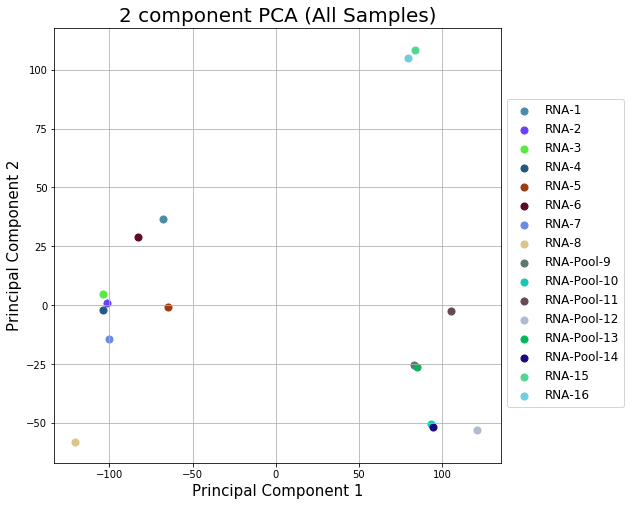

In [142]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA (All Samples)', fontsize = 20)

colors = ['#4b8baa', '#6741fe', '#5be846', '#225783', '#9b3b12', '#5e092c', '#698be4', '#dbc587',
            '#5c7671', '#14c8b6', '#654b51', '#b0bad0', '#07b459', '#200782', '#54d596', '#6dcde3']

for i in range(16):
    ax.scatter(pca_data[i][0], pca_data[i][1], c=colors[i], s=50)
ax.legend(columns, fontsize=12, bbox_to_anchor=(1, 0.85), ncol=1)
ax.grid()

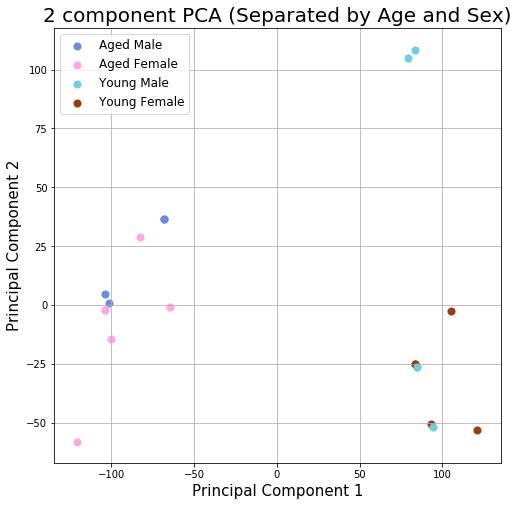

In [143]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA (Separated by Age and Sex)', fontsize = 20)

colors = ['#698be4', '#ffa6e9', '#6dcde3', '#9b3b12']

ax.scatter(pca_data[0][0], pca_data[0][1], c=colors[0], s=50)
ax.scatter(pca_data[3][0], pca_data[3][1], c=colors[1], s=50)
ax.scatter(pca_data[12][0], pca_data[12][1], c=colors[2], s=50)
ax.scatter(pca_data[8][0], pca_data[8][1], c=colors[3], s=50)
for i in range(16):
    if i < 8 and (i < 3 or i > 11):
        index = 0
    elif i < 8 and (i < 12 and i > 2):
        index = 1
    elif i > 8 and (i < 3 or i > 11):
        index = 2
    else:
        index = 3
        
    chosen_color = colors[index]
    ax.scatter(pca_data[i][0], pca_data[i][1], c=chosen_color, s=50)

ax.legend(['Aged Male', 'Aged Female', 'Young Male', 'Young Female'], loc='best', fontsize=12)
ax.grid()

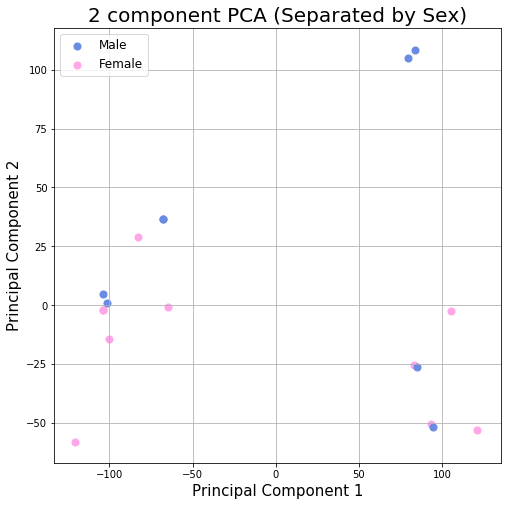

In [144]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA (Separated by Sex)', fontsize = 20)


ax.scatter(pca_data[0][0], pca_data[0][1], c='#698be4', s=50)
ax.scatter(pca_data[3][0], pca_data[3][1], c='#ffa6e9', s=50)
for i in range(16):
    chosen_color = ('#698be4', '#ffa6e9')[i < 12 and i > 2]
    ax.scatter(pca_data[i][0], pca_data[i][1], c=chosen_color, s=50)

ax.legend(['Male', 'Female'], loc='best', fontsize=12)
ax.grid()

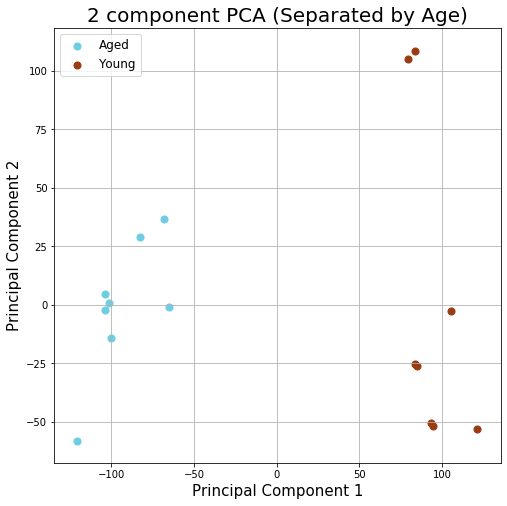

In [145]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA (Separated by Age)', fontsize = 20)

ax.scatter(pca_data[0][0], pca_data[0][1], c='#6dcde3', s=50)
ax.scatter(pca_data[15][0], pca_data[15][1], c='#9b3b12', s=50)
for i in range(1, 15):
    chosen_color = ('#9b3b12', '#6dcde3')[i < 8]
    ax.scatter(pca_data[i][0], pca_data[i][1], c=chosen_color, s=50)

ax.legend(['Aged', 'Young'], loc='best', fontsize=12)
ax.grid()

### Conclusions // Key Points
- Total variance used is ~40%(!)
- PCA makes it easy to separate samples by age
    - Aged samples have negative value for Principal Component 1 while young samples have a positive value for Principal Component 1
- At the same time, PCA provides little info about separating samples by sex

## Part 2: Finding Distinguishing Features
### Using Chi-Square Tests
Here, we begin the process of finding the features that distinguish aged/young samples and male/fale samples. Like before, we begin by importing and cleaning up the data. Unlike before, we also create output vectors (`age_output` `sex_output`) that represent the age and sex of each sample, respectively. 

In [146]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn import feature_selection

data = pd.read_csv(
    filepath_or_buffer='data_matrix.csv',
    header=None,
    sep=',',
    low_memory=False)

# Clean up data, remove row/column headers 
data = data[[0,1,2,3,4,5,6,7,8,11,12,13,14,15,16,9,10]]
columns = data.iloc[0]
columns = columns.drop(0)
rows = data.iloc[:,0]
data = data.drop(0).reset_index(drop=True).drop(0, axis=1).reset_index(drop=True).astype(float)
data = data.to_numpy().transpose()

# Create vectors containing expected outputs
age_outputs = [0]*8 + [1]*8
sex_outputs = [0]*3 + [1]*9 + [0]*4

After setting everything up, we can use a chi-square test on the data that corresponds to age & sex samples. The chi-square tests allows us to use the results of the chi-square test to determine which features are the most important when distinguishing between the two types of sex and two types of age. scikit-learn's built in `SelectKbest` function runs the chi-score and using the results, we can construct a dataframe that stores the relative score for each feature (gene) where a high score signifies a distinguishing feature and a low score represents a less important feature.

In [147]:
def get_chi_df(output):
    '''
    Gets dataframe containing ranked scores for a given output (sex or age)
    '''
    chi2_features = feature_selection.SelectKBest(feature_selection.chi2, k=10) 
    best_features = chi2_features.fit(data, output)
    dfscores = pd.DataFrame(best_features.scores_)
    dfcolumns = pd.DataFrame(rows)
    df = pd.concat([dfcolumns,dfscores],axis=1)
    df.columns = ['Gene','Score']  
    return df

After running `SelectKBest`/the chi-score test, we can sort the dataframes in ascending order to find the top 10 genes that best distinguish between first age (aged vs. young sample) and then sex (male vs. female sample). The results are printed below:

In [148]:
age_scores = get_chi_df(age_outputs)
sex_scores = get_chi_df(sex_outputs)
print('Most Important Genes for Distinguishing Age')
print(age_scores.nlargest(10,'Score')) 
print('\nMost Important Genes for Distinguishing Sex')
print(sex_scores.nlargest(10,'Score'))

Most Important Genes for Distinguishing Age
          Gene          Score
17959    mt-Tv  230029.830722
17957    mt-Tf  229268.355842
21666    Igkj5   55205.097426
17989    mt-Te   30189.341803
17976    mt-Tk   23475.042786
17971    mt-Ty   20708.226201
17977  mt-Atp8   17826.042458
39321  Gm29382   17666.835759
17965    mt-Tm   15360.427105
17961   mt-Tl1   14461.427049

Most Important Genes for Distinguishing Sex
          Gene         Score
17959    mt-Tv  68910.647608
17957    mt-Tf  40919.537621
17989    mt-Te   9963.688052
17976    mt-Tk   8210.853519
32486  Gm24819   6930.495250
9131      Bet1   5757.711018
17971    mt-Ty   5686.726726
17982    mt-Tr   5515.747663
17986   mt-Tl2   5021.831981
21666    Igkj5   4998.404522


### Plotting Chi-Square Results
In order to better visualize the significance of each gene/feature, we can plot each of the top 10 genes relative to one another as follows:

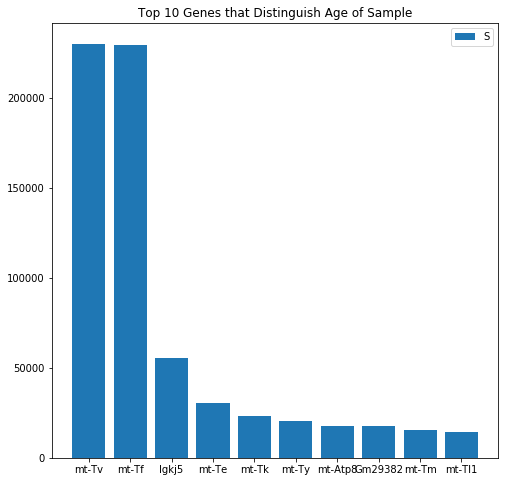

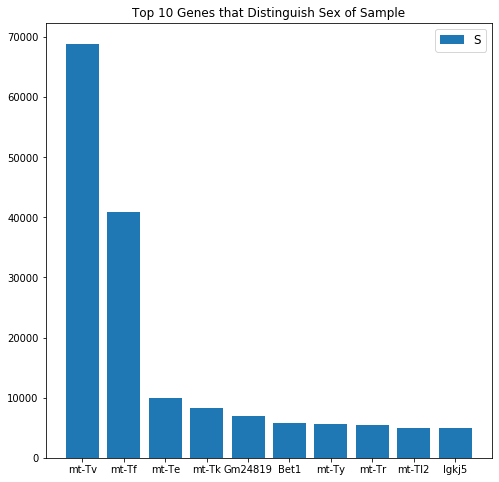

In [149]:
# Plot Bar Graph for Age
ax = plt.subplots(figsize=(8,8))
working_df = age_scores.nlargest(10, 'Score').reset_index(drop=True)
genes = working_df['Gene'].tolist()
working_df.set_index('Gene', inplace=True)
plt.bar(genes, working_df['Score'].tolist())
plt.legend('Score', loc='best')
plt.title('Top 10 Genes that Distinguish Age of Sample')
plt.show()

print()
# Plot Bar Graph for Sex
ax = plt.subplots(figsize=(8,8))
working_df = sex_scores.nlargest(10, 'Score').reset_index(drop=True)
genes = working_df['Gene'].tolist()
working_df.set_index('Gene', inplace=True)
plt.bar(genes, working_df['Score'].tolist())
plt.legend('Score', loc='best', fontsize=12)
plt.title('Top 10 Genes that Distinguish Sex of Sample')
plt.show()

## Conclusions
From this, we are able to see which genes play the largest role in distinguishing the age and sex of samples. Interestingly, for both sex and age, the top two genes are the mt-Tv and mt-Tf genes.